In [21]:
import neural_priors

In [22]:
from neural_priors.utils.plotting import plot_prf_predictions
from neural_priors.utils.data import Subject, get_all_subject_ids, get_all_behavioral_data
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os.path as op
from scipy import stats, odr
from braincoder.models import LogGaussianPRF, GaussianPRF

In [23]:
plt.rcParams['legend.frameon'] = False
np.set_printoptions(linewidth=140)
pd.set_option('display.width', 170) # 80
pd.options.mode.copy_on_write = True
pd.set_option('display.max_columns', 70)

In [24]:
bids_folder = '/data/ds-neuralpriors'

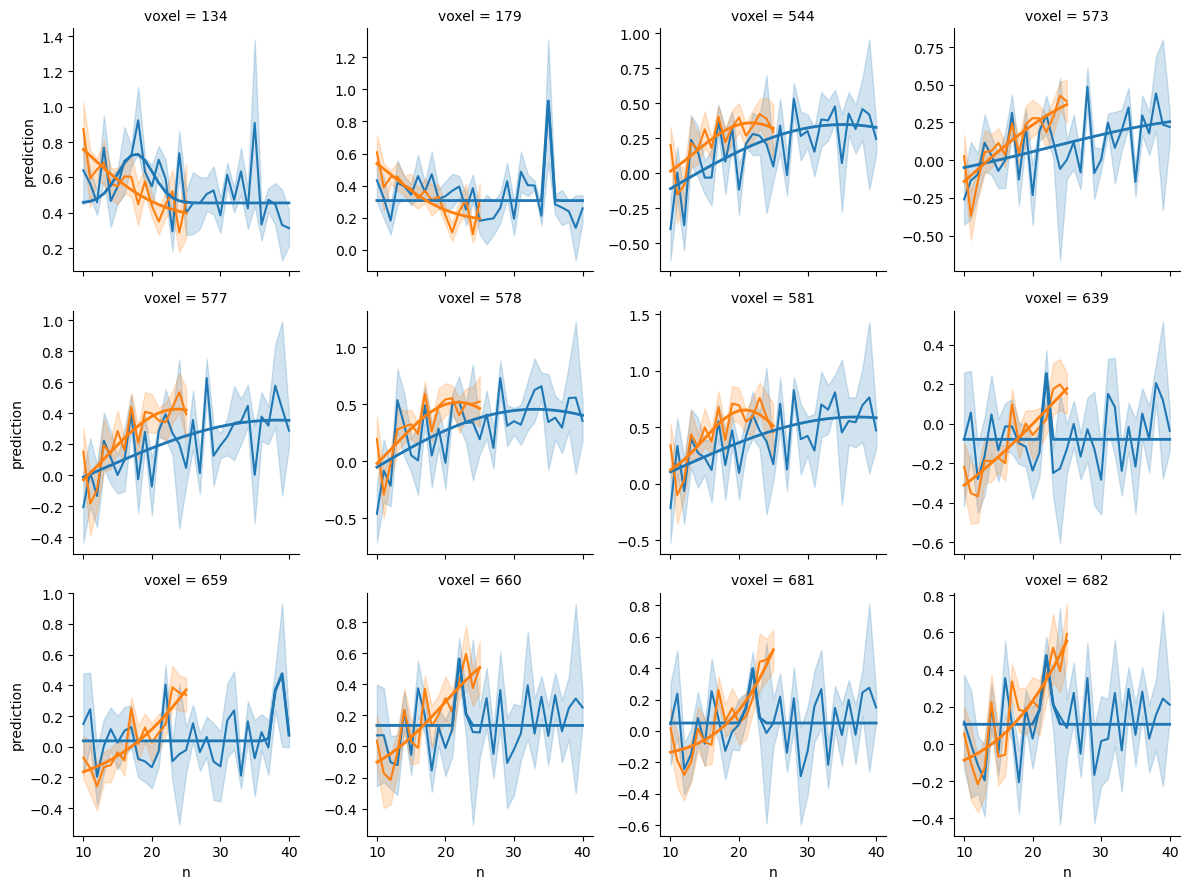

In [25]:
plot_prf_predictions('10', bids_folder=bids_folder, gaussian=True)

2024-05-24 13:04:36.087403: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


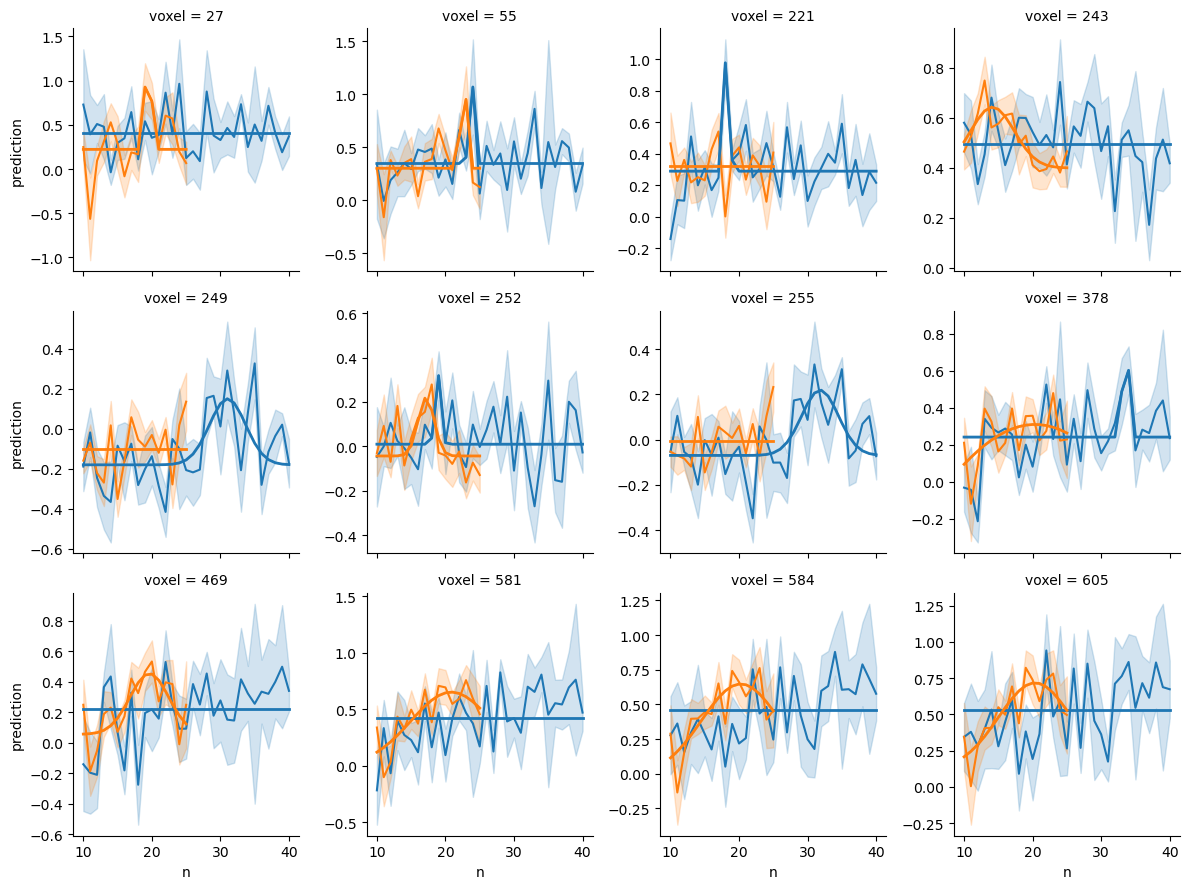

In [5]:
plot_prf_predictions('10', bids_folder=bids_folder, gaussian=True)

In [6]:
get_all_subject_ids()

['01',
 '02',
 '03',
 '04',
 '05',
 '06',
 '07',
 '08',
 '09',
 '10',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '24']

In [26]:
behavior = get_all_behavioral_data(bids_folder=bids_folder) #, subjects=[f'{i}'.rjust(2,'0') for i in range(1,23)])

In [27]:
from tqdm.contrib.itertools import product

In [28]:
load_data_via_tsv = False

if load_data_via_tsv:
    df = pd.read_csv(op.join(bids_folder, 'derivatives', 'encoding_model', 'npcr_parameters.tsv'), sep='\t',
                    index_col=[0, 1, 2, 3, 4, 5,],
                    dtype={'subject':str})
    df.columns.name = 'parameter'
    df.index.set_names('voxel', level=-1, inplace=True)
else:
    df = []
    keys = []
    subjects = get_all_subject_ids()
    #subjects.pop(subjects.index('11'))
    #subjects.pop(subjects.index('16'))

    for subject, range_n, session, smoothed, gaussian in product(subjects, ['wide', 'narrow', None, 'wide2'], [None], [True, False], [False, True]):
    # for subject, range_n, session, smoothed in product(subjects, ['wide', 'narrow', None], [None], [True, False]):
        sub = Subject(subject, bids_folder)
        sub_df = sub.get_prf_parameters_volume(session=session, cross_validated=False, roi='NPCr', smoothed=smoothed, range_n=range_n, gaussian=gaussian)
        if gaussian:
            sub_df = sub_df.rename(columns={'mu':'mode', 'sd':'width'})
        else:
            sub_df = sub_df.rename(columns={'fwhm':'width'})
        df.append(sub_df)
        keys.append((subject,
                    range_n if range_n is not None else 'both', session if session is not None else 'both',
                    'smoothed' if smoothed else 'unsmoothed',
                    'gaussian' if gaussian else 'lognormal'))

    df = pd.concat(df, keys=keys, names=['subject', 'range_n', 'session', 'smoothed', 'model'])
    df.to_csv(op.join(bids_folder, 'derivatives', 'encoding_model', 'npcr_parameters.tsv'), sep='\t')

df = df.unstack(['range_n', 'model', ]).reorder_levels(axis='columns', order=['model', 'parameter', 'range_n'])
df = df.sort_index(axis=1, level=['model'], sort_remaining=False)

  0%|          | 0/352 [00:00<?, ?it/s]

In [29]:
df

model                            gaussian                                                                                                                       \
parameter                            mode                                       width                                 amplitude                                  
range_n                              wide     narrow       both      wide2       wide     narrow       both     wide2      wide     narrow      both     wide2   
subject session smoothed                                                                                                                                         
01      both    smoothed   0    37.331581  21.130262  37.328106  11.521615   0.380676   0.393754   0.369219  0.903927  1.185430   0.684489  1.154732  0.730820   
                           1    33.823978   1.494949  33.827129  11.690054   0.691515   0.930751   0.669060  0.470582  0.749141   1.000000  0.721397  1.063844   
                           2    28.570770  11.896837  28.571964  15.474047   0.455065   0.934175   0.441089  1.315536  0.879009   0.328444  0.838193  0.488743   
                           3    15.578845  12.634643  15.078586  15.590552   1.232632   2.400479   1.201910  1.414796  0.484702   0.272002  0.293433  0.609456   
                           4    11.837032   1.494949  11.579186  11.841673   0.780043   0.930751   1.052789  0.820361  0.961507   1.000000  0.375331  1.067047   
...                                   ...        ...        ...        ...        ...        ...        ...       ...       ...        ...       ...       ...   
24      both    unsmoothed 492  38.960663  16.037647  39.420631  21.221689  27.030067   0.435537   0.574254  0.768259  1.212309   0.729678  0.846027  0.657063   
                           493  42.917103  31.191919  39.522182  14.672663   9.241786   0.677690   0.456291  0.429556  0.414750   1.000000  0.860770  0.736108   
                           494  50.160431  15.259594  50.733070  22.312862  26.523380   0.259572  24.495544  0.382103  0.550941   0.582908  0.363870  0.726376   
                           495  12.138888  60.592590  28.151442  12.118049   0.295219  13.348577   0.285401  0.278125  2.149490  12.189654  1.324293  2.076687   
                           496  11.848742  20.550999  11.600238  11.915381   0.278168   0.287504   0.409443  0.258588  2.085903   2.617463  0.971867  1.841121   

model                                                                                                                                                       lognormal  \
parameter                       baseline                                      r2                                        cvr2                                     mode   
range_n                             wide    narrow      both     wide2      wide        narrow      both     wide2      wide    narrow      both     wide2       wide   
subject session smoothed                                                                                                                                                
01      both    smoothed   0   -0.130047 -0.100742 -0.096932 -0.242528  0.025201  2.050865e-02  0.013216  0.031572 -0.010708 -0.032013 -0.014043 -0.150754  37.329971   
                           1   -0.531587 -0.480002 -0.504918 -0.642029  0.021125  6.556511e-07  0.011212  0.036704 -0.077139 -0.059341 -0.039218 -0.112296  33.805660   
                           2   -0.533938 -0.502003 -0.494765 -0.664763  0.028484  1.959437e-02  0.015086  0.043335 -0.078357 -0.051230 -0.041021 -0.139205  28.579901   
                           3   -0.345751 -0.334168 -0.312876 -0.462194  0.027097  2.759850e-02  0.014950  0.070238 -0.087892 -0.035467 -0.061280 -0.090636  15.417759   
                           4   -0.108688 -0.084063 -0.110316 -0.199107  0.027147  3.576279e-07  0.008204  0.050542 -0.059541 -0.024274 -0.040139 -0.099978  11.764649   
...                                  ...       .

Text(0.5, 1.0, 'cvr2, narrow')

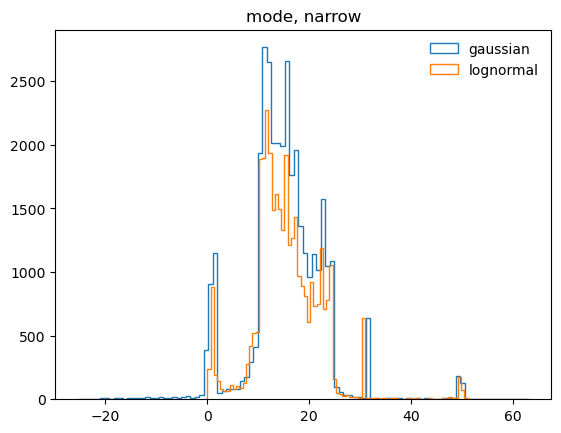

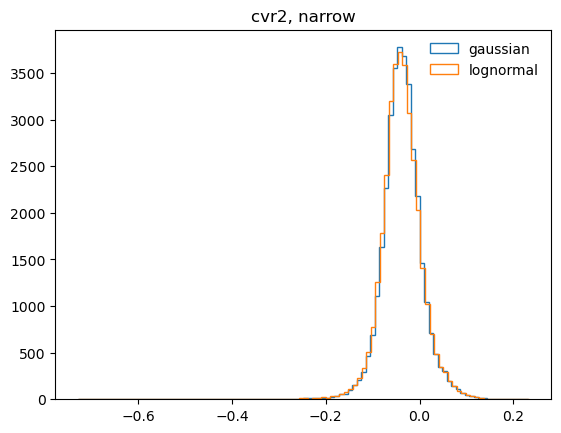

In [30]:
plt.hist( df['gaussian', 'mode', 'narrow'], histtype='step', bins=100, label='gaussian');
plt.hist( df['lognormal', 'mode', 'narrow'], histtype='step', bins=100, label='lognormal');
plt.legend();
plt.title('mode, narrow')
plt.figure()
plt.hist( df['gaussian', 'cvr2', 'narrow'], histtype='step', bins=100, label='gaussian');
plt.hist( df['lognormal', 'cvr2', 'narrow'], histtype='step', bins=100, label='lognormal');
plt.legend();
plt.title('cvr2, narrow')

In [13]:
df.xs(key=('cvr2','wide'), axis=1, level=('parameter','range_n') )

model                           gaussian  lognormal
subject session smoothed                           
01      both    smoothed   0   -0.012855  -0.010084
                           1   -0.077252  -0.077529
                           2   -0.015723  -0.078250
                           3   -0.012954  -0.083956
                           4   -0.059557  -0.054619
...                                  ...        ...
24      both    unsmoothed 492 -0.008867  -0.008867
                           493 -0.018770  -0.018770
                           494 -0.011649  -0.011648
                           495 -0.003020  -0.003240
                           496 -0.004504  -0.004504

[34572 rows x 2 columns]

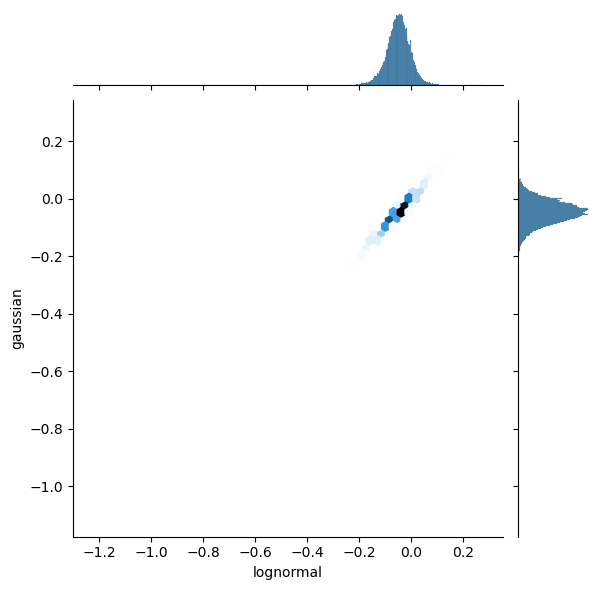

In [31]:
sns.jointplot(data=df.xs(key=('cvr2','wide'), axis=1, level=('parameter','range_n') ), x='lognormal', y='gaussian', kind='hex')

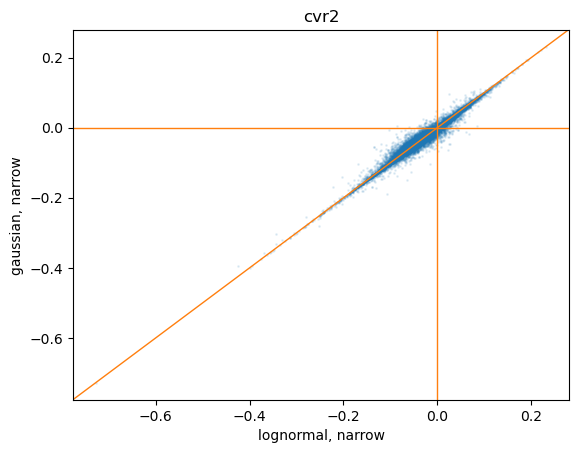

In [32]:
#sns.scatterplot(data=df.xs('cvr2', axis=1, level='parameter'), x='lognormal', y='gaussian', hue='range_n')
plt.scatter(df['lognormal', 'cvr2', 'narrow'], df['gaussian', 'cvr2', 'narrow'], s=1, alpha=.1);
plt.xlabel('lognormal, narrow'); plt.ylabel('gaussian, narrow')
plt.title('cvr2')
plt.axline((0,0), slope=1, c='C1', lw=1)
plt.axhline(0, c='C1', lw=1)
plt.axvline(0, c='C1', lw=1)

<Axes: xlabel="('lognormal', 'width', 'wide')", ylabel='Count'>

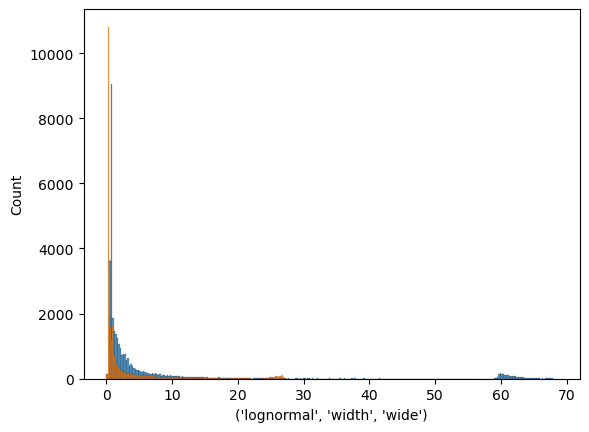

In [37]:
sns.histplot(df[('lognormal', 'width', 'wide')])
sns.histplot(df[('gaussian', 'width', 'wide')])

<Axes: xlabel="('lognormal', 'width', 'narrow')", ylabel='Count'>

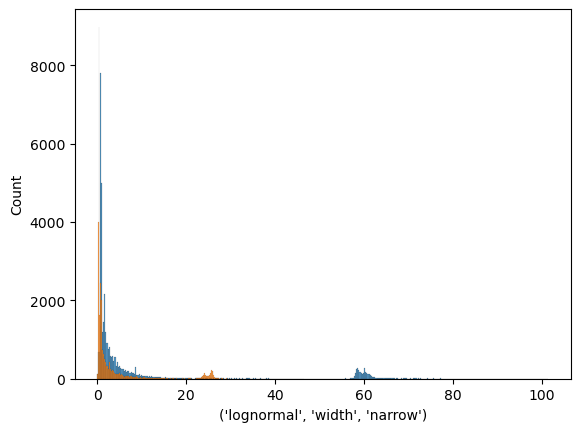

In [38]:
sns.histplot(df[('lognormal', 'width', 'narrow')])
sns.histplot(df[('gaussian', 'width', 'narrow')])

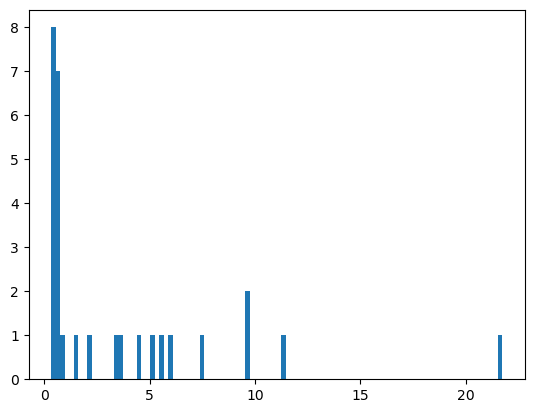

In [33]:
# doing good with lognormal but not with gaussian 
# and have (lognormal) mode in the range
mask = (df[('lognormal', 'cvr2', 'narrow')] > 0.01) & (df[('gaussian', 'cvr2', 'narrow')] < 0.0)
mask &= (df[('lognormal', 'mode', 'narrow')] >= 12 ) & (df[('lognormal', 'mode', 'narrow')] <= 23 )
plt.hist( df[mask][('gaussian','amplitude','narrow')], bins=100);

In [17]:
df[mask][('gaussian','amplitude','narrow')].shape

(579,)

In [18]:
np.mean( df[mask][('gaussian','amplitude','narrow')].values <= 0.001 )

0.0

In [19]:
df[mask]

model                             gaussian                                                                                                                      \
parameter                             mode                                  width                               amplitude                             baseline   
range_n                               wide narrow       both      wide2      wide    narrow      both     wide2      wide narrow      both     wide2      wide   
subject session smoothed                                                                                                                                         
01      both    smoothed   249    1.000000    1.0   1.000000   1.000000  0.930751  0.930751  0.930751  0.930751  1.000000    1.0  1.000000  1.000000  0.619488   
                           303    1.000000    1.0   1.000000   1.000000  0.930751  0.930751  0.930751  0.930751  1.000000    1.0  1.000000  1.000000  0.795876   
                           367    1.000000    1.0   1.000000   1.000000  0.930751  0.930751  0.930751  0.930751  1.000000    1.0  1.000000  1.000000  0.571693   
                           486   19.341639    1.0  14.696855  19.330587  0.313648  0.930751  4.314974  0.310575  0.491972    1.0  0.155396  0.463230  0.453956   
                           527   15.112847    1.0  19.526031  29.212122  0.652357  0.930751  0.327620  0.424628  0.210926    1.0  0.487057  1.000000  0.598474   
...                                    ...    ...        ...        ...       ...       ...       ...       ...       ...    ...       ...       ...       ...   
22      both    unsmoothed 1009  44.060608    1.0   1.000000  17.424730  0.424628  0.930751  0.930751  0.330842  1.000000    1.0  1.000000  3.397552  0.231986   
                           1013  17.429287    1.0   1.000000  17.431469  0.332377  0.930751  0.930751  0.333638  3.777203    1.0  1.000000  3.893436  0.339512   
                           1015   1.000000    1.0   1.000000   1.000000  0.930751  0.930751  0.930751  0.930751  1.000000    1.0  1.000000  1.000000  0.740047   
                           1031   1.000000    1.0   1.000000   1.000000  0.930751  0.930751  0.930751  0.930751  1.000000    1.0  1.000000  1.000000  0.185808   
24      both    unsmoothed 364   44.060608    1.0   1.000000  29.212122  0.424628  0.930751  0.930751  0.424628  1.000000    1.0  1.000000  1.000000  0.730295   

model                                                                                                                                                          \
parameter                                                                r2                                                cvr2                                 
range_n                            narrow      both     wide2          wide        narrow          both         wide2      wide    narrow      both     wide2   
subject session smoothed                                                                                                                                        
01      both    smoothed   249   0.671328  0.645352  0.687668  7.748604e-07  5.960464e-07  1.430511e-06  4.768372e-07 -0.050300 -0.025669 -0.040905 -0.116937   
                           303   0.889060  0.842385  0.892726  4.172325e-07  4.172325e-07  1.013279e-06  5.364418e-07 -0.082168 -0.042200 -0.069587 -0.184527   
                           367   0.645674  0.608819  0.640814  5.364418e-07  6.556511e-07  3.576279e-07  3.576279e-07 -0.064193 -0.041840 -0.056062 -0.118298   
                           486   0.518927  0.422135  0.462909  1.809502e-02  4.768372e-07  2.022326e-02  2.836370e-02 -0.116697 -0.009489 -0.005663 -0.254093   
                           527   0.614145  0.596208  0.607970  1.271904e-02  1.788139e-07  1.617575e-02  8.344650e-07 -0.128880 -0.007271 -0.008713 -0.032563   
...                                   ...       ...       ...           ...           ...           ...           ...   

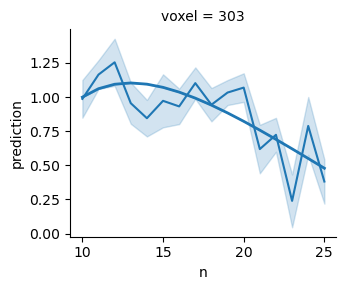

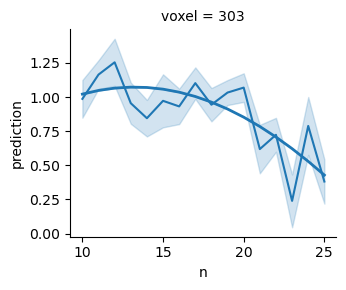

In [34]:
plot_prf_predictions('01', bids_folder=bids_folder, voxels=[303,], range_n='narrow')
plot_prf_predictions('01', bids_folder=bids_folder, voxels=[303,], range_n='narrow', gaussian=True)

In [52]:
df[mask][('lognormal',)].loc['01']

parameter                      mode                                       width                                 amplitude                                baseline  \
range_n                        wide     narrow       both      wide2       wide     narrow       both     wide2      wide    narrow      both     wide2      wide   
session smoothed   voxel                                                                                                                                            
both    smoothed   303     6.002522  12.981236  11.621823  42.080807  62.340797  60.298126  13.123940  3.979798  1.462872  5.552855  0.491395  0.000100 -0.359076   
                   367     0.868931  12.501335  10.356625  28.717173  61.088497  60.136692  13.822925  1.000000  1.626642  3.914020  0.390971  0.000100 -0.507130   
                   486    19.324503  12.911832  13.966791  19.314123   0.758055  60.144726   9.291607  0.747446  0.455764  2.122099  0.162843  0.432489  0.453958   
                   527    15.426988  19.205486  19.518347  28.717173   0.761183   2.309707   0.753075  1.000000  0.494128  0.215076  0.517397  0.000100  0.599008   
                   588    17.641480  19.229942  27.581142  28.717173  63.968790   2.069123   0.722444  1.000000  0.732602  0.207969  0.580544  0.000100 -0.498538   
        unsmoothed 219    38.992310  18.472998  38.990845  28.717173   0.544333   0.815481   0.548288  1.000000  0.549865  0.970604  0.561149  0.000100 -0.103022   
                   305     9.270807  12.085235   7.929293  11.795282  64.537900  58.885628  24.838385  2.290567  3.757507  9.134395  1.851090  0.957541 -1.327358   

parameter                                                     r2                                        cvr2                                
range_n                     narrow      both     wide2      wide    narrow      both         wide2      wide    narrow      both     wide2  
session smoothed   voxel                                                                                                                    
both    smoothed   303   -4.449759  0.582453  0.892780  0.050166  0.110665  0.065538  5.364418e-07 -0.033749  0.018553 -0.003247 -0.219133  
                   367   -3.102900  0.408751  0.640657  0.039792  0.090889  0.054550  3.576279e-07 -0.019835  0.013327 -0.003136 -0.115077  
                   486   -1.520109  0.420259  0.462910  0.018095  0.046848  0.019622  2.836353e-02 -0.102357  0.021762 -0.019899 -0.230986  
                   527    0.577877  0.596209  0.607895  0.012681  0.032683  0.016175  7.152557e-07 -0.129923  0.010743 -0.014121 -0.032514  
                   588    0.117494  0.156174  0.202502  0.017288  0.028330  0.007891  7.152557e-07 -0.109157  0.022012 -0.045768 -0.063373  
        unsmoothed 219   -0.174538 -0.114177 -0.133202  0.024562  0.031934  0.013311  6.556511e-07 -0.067512  0.010049 -0.038295 -0.153228  
                   305   -6.712466  0.669472  1.983647  0.079490  0.122796  0.084518  5.565202e-02  0.034910  0.060188  0.041411 -0.132295

In [54]:
from scipy import optimize

[10.06897582  1.20904566 -0.12288541]


(0.0, 1.35)

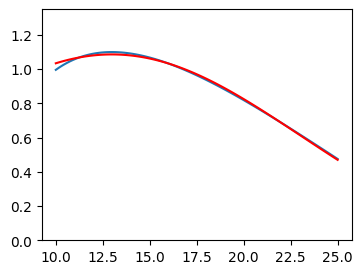

In [59]:
plt.figure(figsize=(4,3))
xxx = np.linspace(10,25,100)
model = LogGaussianPRF(parameterisation='mode_fwhm_natural')
yyy = model.predict(xxx, parameters=pd.DataFrame(data=[[12.98,60.29,5.55,-4.45],], columns=['mode', 'fwhm', 'amplitude', 'baseline']) ).values.flatten()
plt.plot(xxx, yyy)
#plt.plot(xxx, model.predict(xxx, parameters=pd.DataFrame(data=[[12.5,33,1,-0.7],], columns=['mode', 'fwhm', 'amplitude', 'baseline']) ) )
def objf(x):
    σ, a, b = x
    zzz = b + a*np.exp(-.5*((xxx-12.98)/σ)**2)
    r = ((zzz-yyy)**2).mean()
    #print(x,r)
    return r
res = optimize.minimize(objf, x0=[10, 1, -.7], bounds=[(0.,None), (0.,None), (None,None)])
_σ, _a, _b = res.x
print(res.x)
plt.plot(xxx, _b + _a*np.exp(-.5*((xxx-12.98)/_σ)**2), c='r')
#plt.plot(xxx, -.7 + 1*np.exp(-.5*((xxx-12.5)/10)**2), ls='--')
plt.ylim(0,1.35)

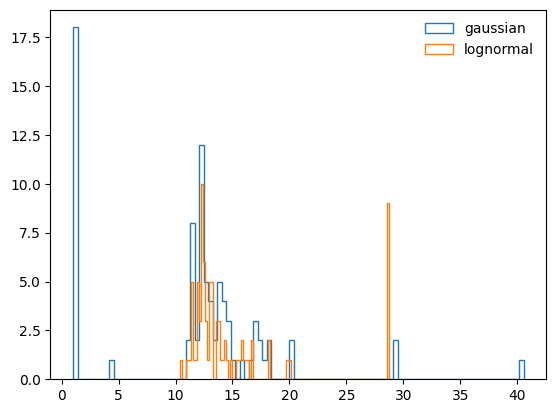

In [103]:
mask = (df[[('gaussian', 'cvr2', 'wide'), ('gaussian', 'cvr2', 'narrow')]].mean(1) > 0.01)
#mask &= (df[('gaussian', 'mode', 'narrow')] >= 10)
plt.hist( df[mask]['gaussian', 'mode', 'narrow'], histtype='step', bins=100, label='gaussian');
plt.hist( df[mask]['lognormal', 'mode', 'narrow'], histtype='step', bins=100, label='lognormal');
plt.legend();

In [25]:
for c in df['mode'].columns:

    mode = df[('mode', c)]
    fwhm = df[('fwhm', c)]

    df[('log_sigma', c)] = 1./(np.sqrt(2.*np.log(2.))) * np.arcsinh(fwhm/(mode*2.))
    df[('log(mode)', c)] = np.log(mode)

/Users/apc/Documents/Neuro/numerosity-fmri/neural_priors/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/apc/Documents/Neuro/numerosity-fmri/neural_priors/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/apc/Documents/Neuro/numerosity-fmri/neural_priors/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/apc/Documents/Neuro/numerosity-fmri/neural_priors/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


/var/folders/jq/_79_qpxx3vd0thkqqmw37l1c0000gn/T/ipykernel_25285/267291279.py:1: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  tmp = df.stack('range_n')


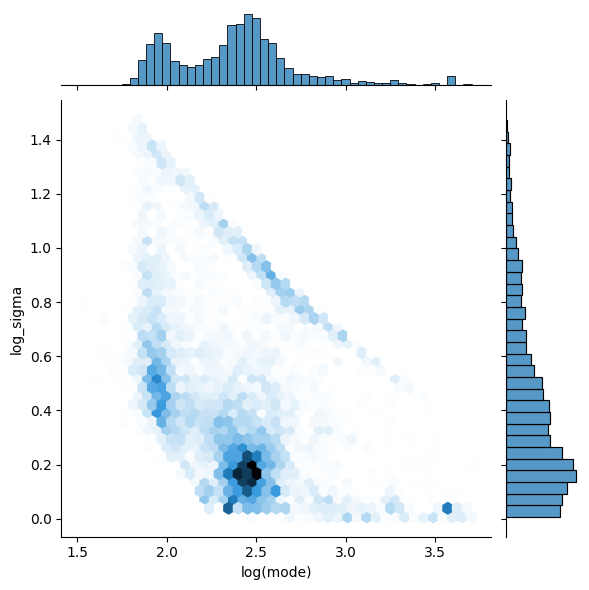

In [26]:
tmp = df.stack('range_n')
tmp = tmp[tmp.cvr2 > 0.01]
sns.jointplot(x='log(mode)', y='log_sigma', data=tmp.reset_index(), kind='hex')